# Cubic stiffness SDOF PINN

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \ddot{x} + c \dot{x} + kx + k_3x^3= F_x~, \qquad \ddot{x} + \tilde{c} \dot{x} + \tilde{k}x +\tilde{k}_3x^3 = \tilde{F}_x~, \qquad \tilde{\bullet} = \frac{\bullet}{m}
$$
with the initial conditions and forcing,
$$
x(0) = 0\mathrm{mm}~~,~~\dot{x}(0) = 0, \qquad F_x = F_0\sin(\omega_t)
$$

<!-- Ground truth is simulated using M. Champneys' `mdof-toybox` package -->

In [1]:
from sdof_pinn import bbnn, sdof_pinn, normalise, ParamClipper
from sdof_oscillators import sdof_solution, add_noise, generate_excitation

import numpy as np
import torch
import torch.nn as nn

from scipy.stats import qmc

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

### Generate Forcing

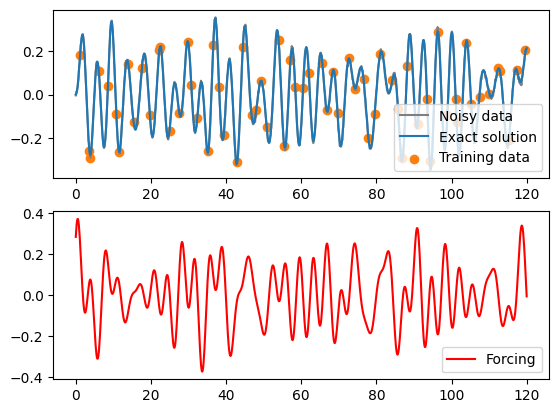

In [2]:
nt = 1024
t = np.linspace(0,120,nt)

F0 = 0.1  # N

# excitation = {
#     "type" : "sinusoid",
#     "F0" : F0,
#     "w" : 1.6  # rad/s
# }

excitation = {
    "type" : "rand_phase_ms",
    "F0" : F0,
    "freqs" :   np.array([0.7, 0.85, 1.6, 1.8]),
    "Sx" :      np.array([1.0, 1.0, 1.0, 1.0])
}

# excitation = {
#     "type" : "white_gaussian",
#     "F0" : F0,
#     "offset" :   0.0
# }

# excitation = {
#     "type" : "sine_sweep",
#     "F0" : F0,
#     "w" :   np.array([0.4, 2.8]),
#     "scale" :  "linear"
# }

F = generate_excitation(t, **excitation)
excitation["F"] = F.reshape(-1)

### Generate training and ground truth
m = 10.0
c = 1.0
k = 15.0
k3 = 100.0
excitation["F_tild"] = excitation["F"]/m

wn = np.sqrt(k/m)
zeta = c/(2*m*wn)
wd = wn*np.sqrt(1-zeta**2)

k_tild = k/m
c_tild = c/m
k3_tild = k3/m

gt_config = {
    "nonlinearity" : "cubic",
    # "m_norm" : False,
    # "params" : {
    #     "m" : m,
    #     "k" : k,
    #     "c" : c,
    #     "k3" : k3
    # },
    "m_norm" : True,
    "params" : {
        "k_tild" : k_tild,
        "c_tild" : c_tild,
        "k3_tild" : k3_tild
    },
    "init_conds" : {
        "x0" : 0.0,
        "v0" : 0.0,
        "a0" : 0.0
    },
    "forcing" : excitation
}

x, v = sdof_solution(t, **gt_config)
x_noisy = add_noise(x.view(-1,1), 0.02)
t = torch.tensor(t).view(-1,1).to(torch.float32)

# slice out a number of points from the start of the signal
sampler = qmc.Sobol(d=1, seed=43810)
sub_ind = np.sort(sampler.integers(l_bounds=nt, n=int(nt/16)), axis=0).squeeze()
# sub_ind = np.arange(0, int(nt/1), 16)

t_data = t[sub_ind]
x_data = x_noisy[sub_ind]

fig, axs= plt.subplots(2,1)
axs[0].plot(t, x_noisy, color="gray", label="Noisy data")
axs[0].plot(t, x, label="Exact solution")
axs[0].scatter(t_data, x_data, color="tab:orange", label="Training data")
axs[0].legend()

axs[1].plot(t, excitation["F_tild"], color="red", label="Forcing")
axs[1].legend()

Normalise

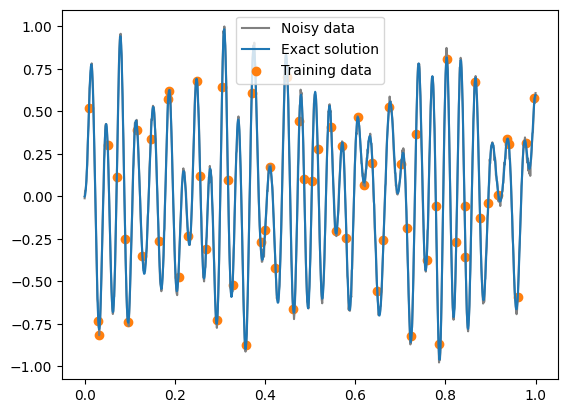

In [3]:
t_hat, alpha_t = normalise(t, "range")
x_hat, alpha_x = normalise(x_noisy, "range")
F_hat, alpha_F = normalise(excitation["F_tild"], "range")
x_hat_gt = x/alpha_x
t_data = t_hat[sub_ind]
x_data = x_hat[sub_ind]
alphas = {
    "t" : alpha_t,
    "x" : alpha_x
}
excitation["F_hat"] = F_hat

fig, ax = plt.subplots()
ax.plot(t_hat, x_hat, color="gray", label="Noisy data")
ax.plot(t_hat, x_hat_gt, label="Exact solution")
ax.scatter(t_data, x_data, color="tab:orange", label="Training data")
ax.legend()

## 'Black-box' network

$$
\textrm{argmin}\mathcal{L}(t;\mathbf{\theta}) := \langle \hat{x}^* - \mathcal{N}_x \rangle
$$

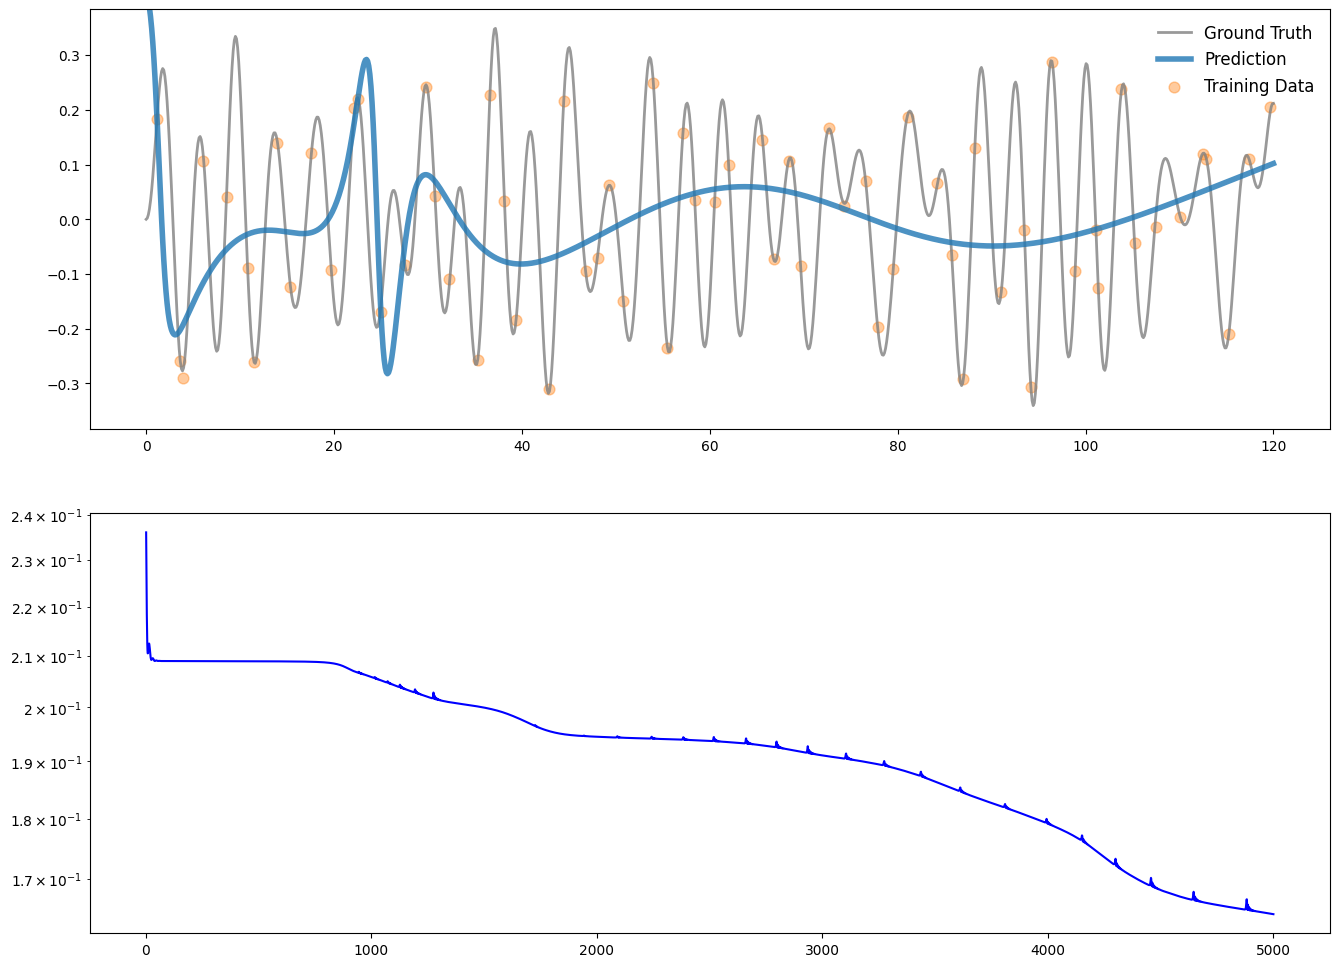

  1%|          | 5138/1000000 [00:02<10:48, 1535.17it/s]

Epoch : 5000 ---- Loss: 1.64e-01 ---- LR 5.00e-04 --> 5.00e-04


  1%|          | 9765/1000000 [00:04<07:06, 2322.42it/s]


KeyboardInterrupt: 

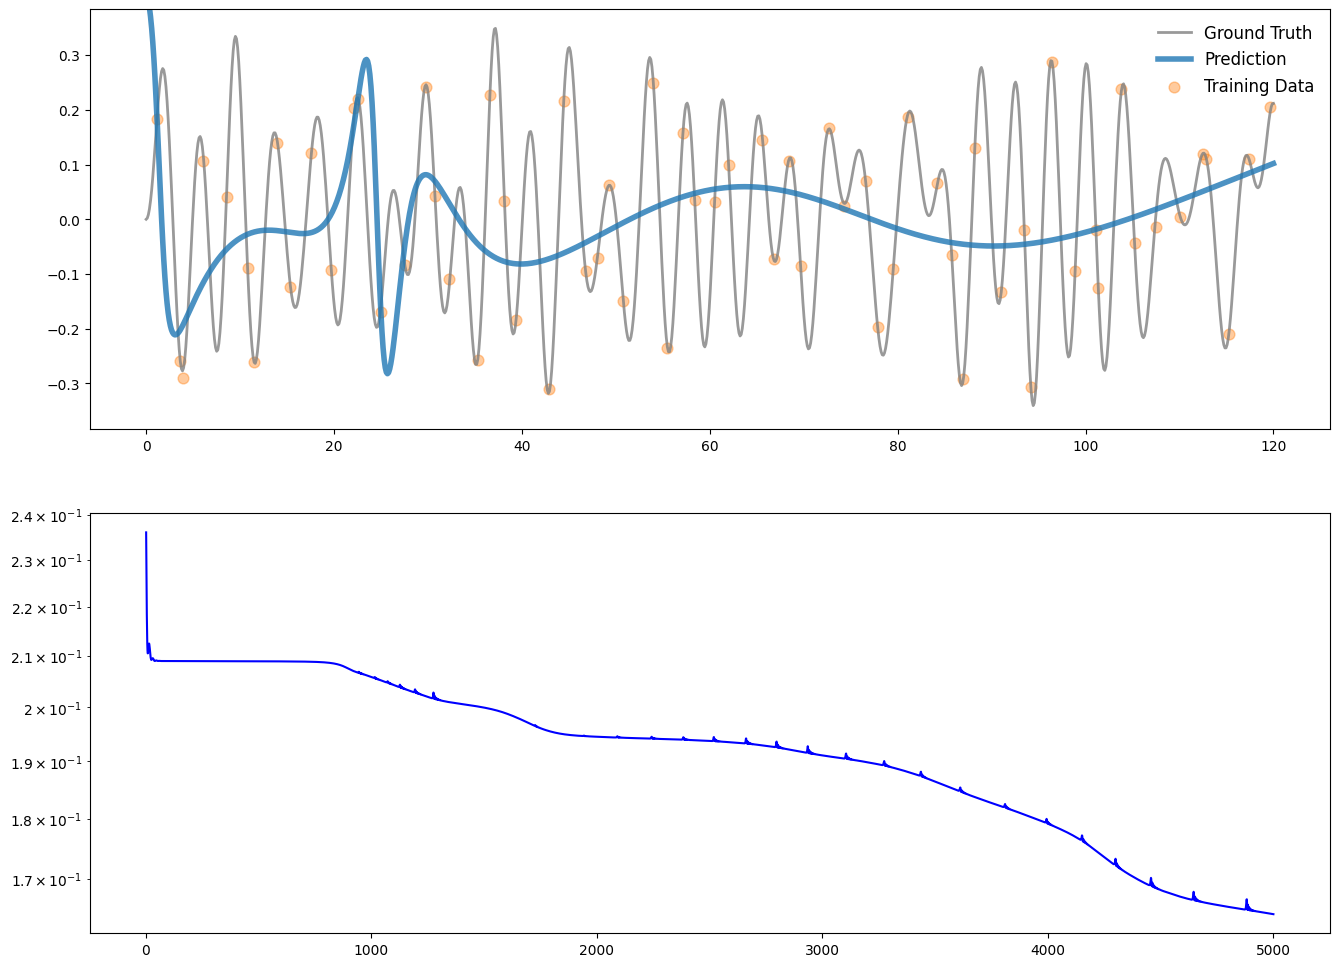

In [4]:
def plot_result(ax, t_hat, x_hat, t_data, x_data, tpred, xpred, alphas):
    ax.cla()
    ax.plot(t_hat*alphas["t"], x_hat*alphas["x"], color="grey", linewidth=2, alpha=0.8, label="Ground Truth")
    ax.plot(tpred*alphas["t"], xpred*alphas["x"], color="tab:blue", linewidth=4, alpha=0.8, label="Prediction")
    ax.scatter(t_data*alphas["t"], x_data*alphas["x"], s=60, color="tab:orange", alpha=0.4, label='Training Data')
    l = ax.legend(frameon=False, fontsize="large")
    xL = torch.amax(t_hat)*alphas["t"]
    yL = torch.amax(torch.abs(x_hat))*alphas["x"]
    ax.set_xlim(-0.05*xL, 1.05*xL)
    ax.set_ylim(-1.1*yL, 1.1*yL)

def plot_loss_hist(ax,loss_hist):
    ax.cla()
    n_epoch = len(loss_hist)
    ax.plot(np.arange(1,n_epoch+1),loss_hist,'b')
    ax.set_yscale('log')
    
# train standard neural network to fit training data
torch.manual_seed(123)
epochs = int(1000e3)
bb_model = bbnn(1,1,32,4)
optimizer = torch.optim.Adam(bb_model.parameters(),lr=5e-4)
loss_hist = []
fig, axs = plt.subplots(2,1,figsize=(16,12),facecolor='w')
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10000, min_lr=1e-5)

for i in tqdm(range(epochs)):
    optimizer.zero_grad()
    loss = bb_model.loss_func(t_data, x_data)
    loss_hist.append(loss.item())
    loss.backward()
    optimizer.step()
    lr_1 = optimizer.param_groups[0]["lr"]
    # scheduler.step(loss)
    lr_2 = optimizer.param_groups[0]["lr"]
    
    # plot the result as training progresses
    if (i+1) % 5000 == 0:
        
        xpred = bb_model(t_hat).detach()
        
        plot_result(axs[0], t_hat, x_hat_gt, t_data, x_data, t_hat, xpred, alphas)

        plot_loss_hist(axs[1],loss_hist)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        tqdma.write("Epoch : %d ---- Loss: %.2e ---- LR %.2e --> %.2e" % (i+1,loss, lr_1, lr_2))

display.clear_output()

## PINN

$$
\textrm{argmin}\mathcal{L}(t;\mathbf{\theta}) = \mathcal{L}_a + \Lambda\mathcal{L}_{ode}
$$

$$
\mathcal{L}_a = \langle \hat{x}^* - \mathcal{N}_{\hat{x}} \rangle _{\Omega_a}, \qquad
\mathcal{L}_{ode} = \langle \hat{m} \partial^2_{\hat{t}}\mathcal{N}_{\hat{x}} + \hat{c} \partial_{\hat{t}}\mathcal{N}_{\hat{x}} + \hat{k}\mathcal{N}_{\hat{x}} + \hat{k}_3\mathcal{N}_{\hat{x}}^3 - \eta \hat{F}\rangle _{\Omega_d}
$$
where,
$$ \mathcal{N}_{\bullet} = \mathcal{N}_{\bullet}(\mathbf{x};\mathbf{\theta}), \qquad 
\partial_{*}\bullet = \frac{\partial\bullet}{\partial *}, \qquad 
\partial^2_{*}\bullet = \frac{\partial^2\bullet}{\partial *^2}, \qquad
\langle\bullet\rangle _{\Omega_{\kappa}} = \frac{1}{N_{\kappa}}\sum_{x\in\Omega_{\kappa}}\left|\left|\bullet\right|\right|^2 $$

ODE loss function comes from including the normalisation of the parameters, then choosing the suitable range to aid optimisation.

$$
\frac{1}{\alpha_t^2} \partial^2_{\hat{t}}\hat{x} + 
\tilde{c}\frac{1}{\alpha_t}\partial_{\hat{t}}\hat{x} + 
\tilde{k} \hat{x} +
\tilde{k}_3 \alpha_x^2 \hat{x}^3 - 
\frac{\alpha_F}{\alpha_x} \hat{F} = 0 
\quad \rightarrow \quad 
\hat{m} \partial^2_{\hat{t}}\hat{x} + 
\hat{c} \partial_{\hat{t}}\hat{x} + 
\hat{k}\hat{x} + \hat{k}_3\hat{x}^3
- \eta\hat{F} = 0
$$
To scale loss function in a physically meaningful way, multiply the loss function by any of the following:
$$
\Lambda = 1, \alpha_t, \alpha_t^2, \alpha_x^, \alpha_F^{-1}
$$

 23%|██▎       | 1159999/5000000 [38:05<2:06:06, 507.47it/s]


KeyboardInterrupt: 

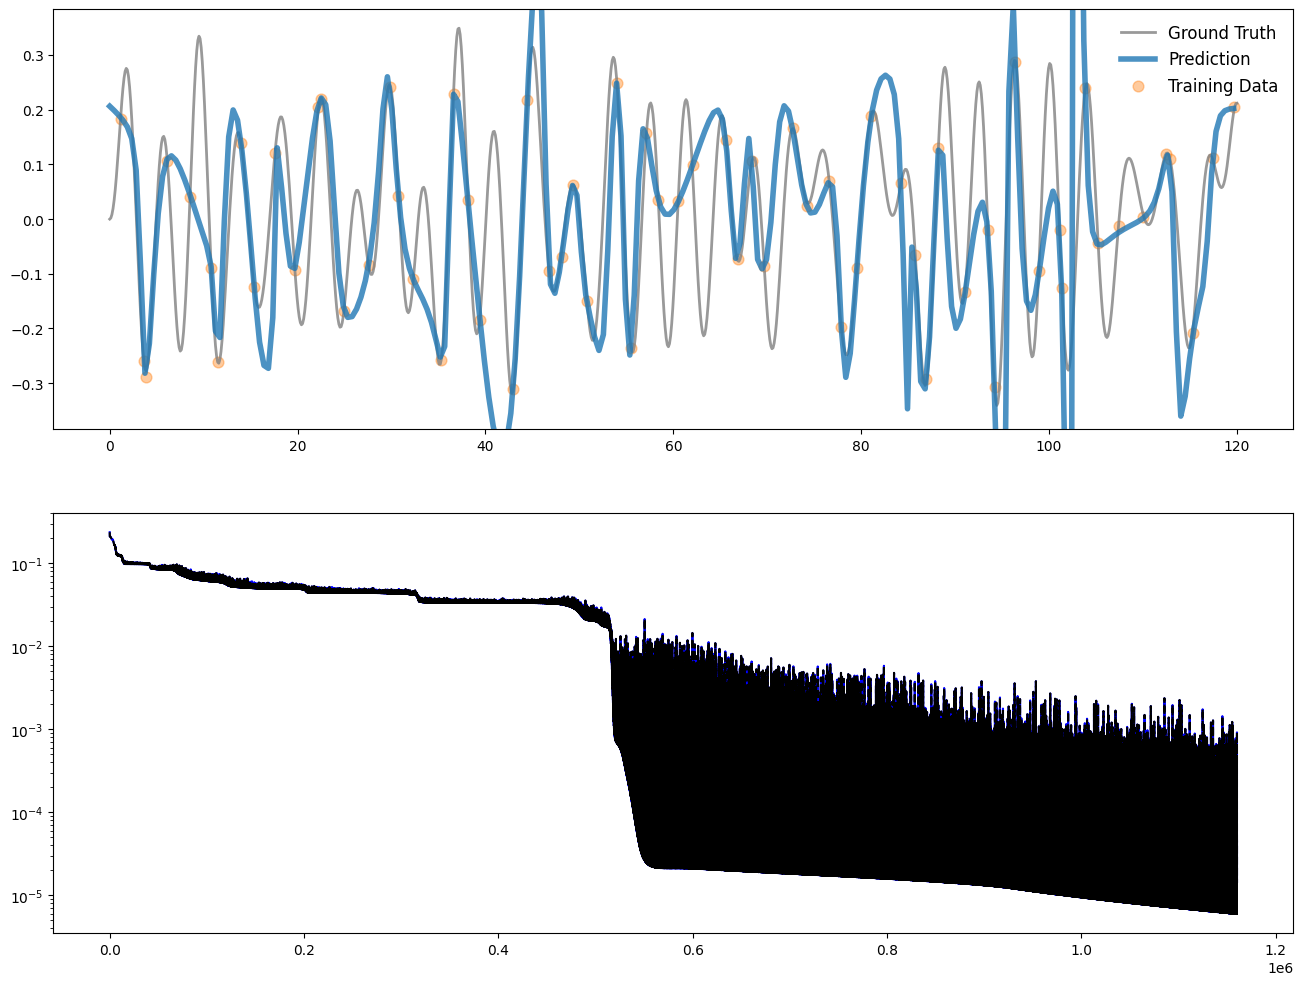

In [6]:
alpha_c = c_tild*10
alpha_k = k_tild*10
alpha_k3 = k3_tild*10
alphas = {
    "c" : alpha_c,
    "k" : alpha_k,
    "k3" : alpha_k3,
    "t" : alpha_t,
    "x" : alpha_x,
    "F" : alpha_F
}
excitation["F_hat"] = excitation["F_tild"][::4]/alpha_F

def plot_joint_loss_hist(ax,loss_hist):
    n_epoch = len(loss_hist)
    ax.cla()
    ax.plot(np.arange(1,n_epoch+1),loss_hist[:,0],'b',label="Observation loss")
    ax.plot(np.arange(1,n_epoch+1),loss_hist[:,1],'g',label="IC loss")
    ax.plot(np.arange(1,n_epoch+1),loss_hist[:,2],'r',label="Physics loss")
    ax.plot(np.arange(1,n_epoch+1),loss_hist[:,3],'k--',label="Total loss")
    ax.set_yscale('log')
    # ax.set_ylim((1e-4,1e-1))

torch.manual_seed(123)
pi_model = sdof_pinn(
    N_INPUT = 1,
    N_OUTPUT = 1,
    N_HIDDEN = 32,
    N_LAYERS = 4
    )

pinn_config = {
    "nonlinearity" : "cubic",
    "phys_params" : {
        "par_type" : "constant",
        "k": k_tild,
        "c" : c_tild,
        "k3" : k3_tild
    },
    # "phys_params" : {
    #     "par_type" : "variable",
    #     "k": 1.0,
    #     "c" : 1.0,
    #     "k3" : 1.0
    # },
    "init_conds" : gt_config["init_conds"],
    "alphas" : alphas,
    "ode_norm_Lambda" : 1.0,
    "forcing" : excitation
}

# configure pinn
pi_model.configure(**pinn_config)

ntp = nt  # number of collocation points
# t_physics = torch.linspace(0, torch.max(t_hat), ntp).view(-1,1).requires_grad_()
t_physics = t_hat[::4].clone().view(-1,1).requires_grad_()

epochs = int(5000e3)
betas = (0.9,0.999)
optimizer = torch.optim.Adam(pi_model.parameters(),lr=5e-4,betas=betas)

clipper = ParamClipper()

fig, axs = plt.subplots(2,1,figsize=(16,12),facecolor='w')
loss_hist=[]
lambds = {
    'obs' : torch.tensor(1.0),
    'ic' : torch.tensor(0.0),
    'ode' : torch.tensor(0.0)
}

for i in tqdm(range(epochs)):
    optimizer.zero_grad()

    loss, losses = pi_model.loss_func(t_physics, t_data, x_data, lambds)

    loss_hist.append([losses[0].item(), losses[1].item(), losses[2].item(), loss.item()])
    loss.backward()
    optimizer.step()
    # scheduler.step(loss)

    pi_model.apply(clipper)
    
    # plot the result as training progresses
    if (i+1) % 2000 == 0: 
        
        xpred = pi_model(t_physics).detach()
        
        plot_result(axs[0], t_hat, x_hat_gt, t_data, x_data, t_physics.detach(), xpred, alphas)

        plot_joint_loss_hist(axs[1],np.array(loss_hist))
        
        display.clear_output(wait=True)
        display.display(plt.gcf())

        match pi_model.param_type:
            case "constant":
                tqdma.write("Epoch : %d ---- Loss: %.2e" % (i+1,loss))
            case "variable":
                tqdma.write("Epoch : %d ---- Loss: %.2e \nc_tild: %.4f ---- k_tild: %.4f ---- k3_tild: %.4f" % (i+1,loss,pi_model.phys_params[0]*alphas['c'],pi_model.phys_params[1]*alphas['k'],pi_model.phys_params[2]*alphas['k3']))

display.clear_output()
match pi_model.param_type:
            case "constant":
                tqdma.write("Epochs : %d ---- Loss: %.2e" % (i+1,loss))
            case "variable":
                tqdma.write("Epoch : %d ---- Loss: %.2e \nc_tild: %.4f ---- k_tild: %.4f ---- k3_tild: %.4f" % (i+1,loss,pi_model.phys_params[0]*alphas['c'],pi_model.phys_params[1]*alphas['k'],pi_model.phys_params[2]*alphas['k3']))

In [15]:
checkpoint = {
    'epoch' : i,
    'model' : pi_model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'loss' : loss_hist,
    # 'scheduler' : scheduler
}
torch.save(checkpoint,'checkpoints/sdof_forced_cubic_pg_s.pth')

Epochs : 1000000 ---- Loss: 1.08e-04


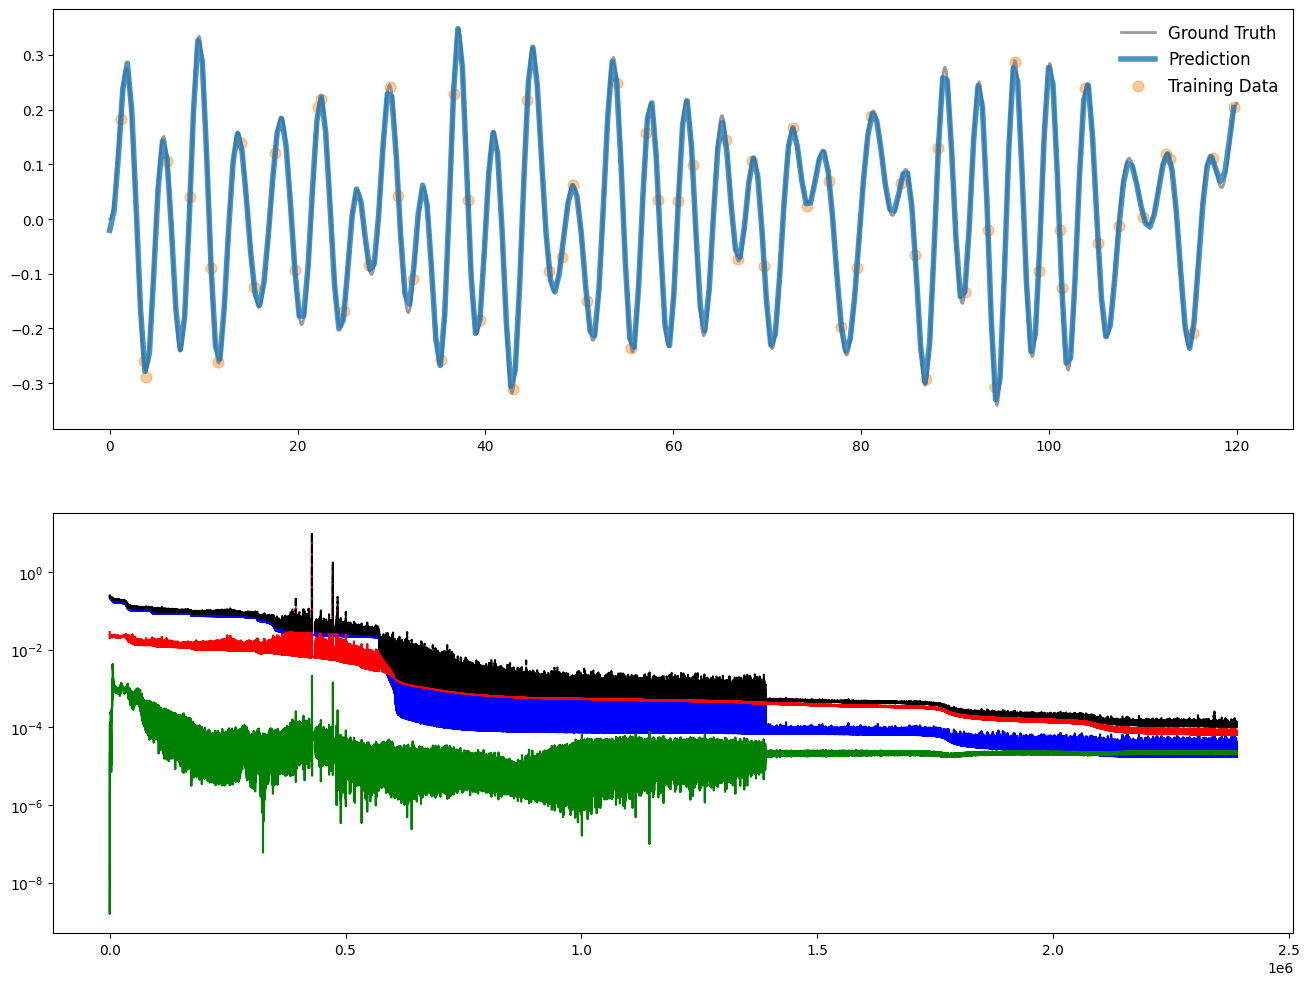

In [6]:
checkpoint = torch.load('checkpoints/sdof_forced_cubic_pg_s.pth')
loss_hist = checkpoint["loss"]
pi_model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

for g in optimizer.param_groups:
    g['lr'] = 1e-4
    # g['betas'] = (0.98,0.999)

fig, axs = plt.subplots(2,1,figsize=(16,12),facecolor='w')
epochs = int(1000e3)

lambds = {
    'obs' : torch.tensor(1.0),
    'ic' : torch.tensor(0.1),
    'ode' : torch.tensor(1.0)
}

for i in tqdm(range(epochs)):
    optimizer.zero_grad()

    loss, losses = pi_model.loss_func(t_physics, t_data, x_data, lambds)

    loss_hist.append([losses[0].item(), losses[1].item(), losses[2].item(), loss.item()])
    loss.backward()
    optimizer.step()

    # pi_model.apply(clipper)
    
    # plot the result as training progresses
    if (i+1) % 500 == 0: 
        
        xpred = pi_model(t_physics).detach()
        
        plot_result(axs[0], t_hat, x_hat_gt, t_data, x_data, t_physics.detach(), xpred, alphas)

        plot_joint_loss_hist(axs[1],np.array(loss_hist))
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        match pi_model.param_type:
            case "constant":
                tqdma.write("Epoch : %d ---- Loss: %.2e" % (i+1,loss))
            case "variable":
                tqdma.write("Epoch : %d ---- Loss: %.2e \nc_tild: %.4f ---- k_tild: %.4f ---- k3_tild: %.4f" % (i+1,loss,pi_model.phys_params[0]*alphas['c'],pi_model.phys_params[1]*alphas['k'],pi_model.phys_params[2]*alphas['k3']))

display.clear_output()
match pi_model.param_type:
            case "constant":
                tqdma.write("Epochs : %d ---- Loss: %.2e" % (i+1,loss))
            case "variable":
                tqdma.write("Epoch : %d ---- Loss: %.2e \nc_tild: %.4f ---- k_tild: %.4f ---- k3_tild: %.4f" % (i+1,loss,pi_model.phys_params[0]*alphas['c'],pi_model.phys_params[1]*alphas['k'],pi_model.phys_params[2]*alphas['k3']))

In [7]:
ground_truth = {
    "t_hat" : t_hat,
    "x_hat" : x_hat_gt
}

data = {
    "t_hat" : t_data,
    "x_hat" : x_data
}

prediction = {
    "t_hat" : t_physics,
    "x_hat" : xpred
}

result_data = {
    'epoch' : i,
    'gt_config' : gt_config,
    'osa_config' : pinn_config,
    'model' : pi_model.state_dict(),
    'loss' : loss_hist,
    'ground_truth' : ground_truth,
    'data' : data,
    'prediction' : prediction,
    'alphas' : alphas
}

torch.save(result_data, 'results/sdof_forced_cubic_bb.pth')